# Practical 3 - Dimensionality Reduction and Clustering

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. For each of these cells, the expression of several thousand genes was measured. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison.


In [1]:
# Prepare
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy as sp

## Task 0: Load and normalize count data

In [2]:
def lognormalize_counts(tasic_dict):
    
    #normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1) 
    tasic_dict['logCPM'] = logCPM  
    
    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(pickle.load(open('data/tasic_subset_1kselected.pickle', 'rb')))

FileNotFoundError: [Errno 2] No such file or directory: 'data/tasic_subset_1kselected.pickle'

## Task 1: Linear dimensionality reduction with PCA [15 points]

In this task, you will use principle component analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use `numpy.linalg.eig()`  but no `sklearn`-functions. Write a function that computes all possible principle components, and returns them along with the fraction of variance they explain.

In [6]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###

    # INSERT YOUR CODE HERE

    
    ### TO BE REMOVED ###
    gene_means = np.mean(data,axis=0)
    log_cpm_centered = data - gene_means
    cov = np.cov(log_cpm_centered,rowvar=False)
    eigenvalues,principal_components = np.linalg.eig(cov)
    sum_eigenvalues =sum(eigenvalues)
    fraction_variance_explained = eigenvalues/sum_eigenvalues
    ### TO BE REMOVED ###
    
    return fraction_variance_explained,principal_components


In [7]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

Before we explore the structure of the low dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the variance explained of the `n`-th PC vs. `n`

- Plot the cumulative variance explained for the `n` PCs with highest variance explained vs. `n`

From the latter plot you should be able to see how much PCs you need to keep to explain at least `x`% of the variance.

How many components to you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

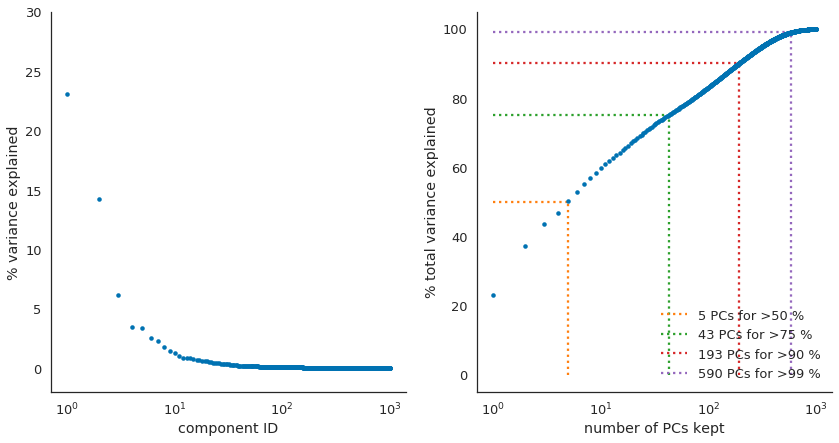

In [55]:
# Here I would remove the plotting code but keep the skeleton with the plt.figure and the subplots

### TO BE REMOVED ###
n_PCs = len(var_expl)
PC_ids = np.arange(1,n_PCs+1)
### TO BE REMOVED ###

plt.figure(figsize=(14,7))

plt.subplot(121)

### TO BE REMOVED ###
plt.plot(PC_ids,100*var_expl,'.')
plt.xlabel('component ID')
plt.ylabel('% variance explained')
plt.xscale('log')
plt.ylim(-2,30)
### TO BE REMOVED ###


plt.subplot(122)

### TO BE REMOVED ###
total_variance_explained = np.cumsum(100*var_expl)
plt.plot(PC_ids,total_variance_explained,'.')
plt.xlabel('number of PCs kept')
plt.ylabel('% total variance explained')
for variance_level,c in zip([50,75,90,99],['tab:orange','tab:green','tab:red','tab:purple']):
    n_PCs_needed = sum(total_variance_explained<variance_level) + 1
    legend_string = '%u PCs for >%u %%' % (n_PCs_needed,variance_level)
    plt.hlines(variance_level,1,n_PCs_needed,label=legend_string,colors=c,linestyles=':')
    plt.vlines(n_PCs_needed,0,variance_level,colors=c,linestyles=':')
leg = plt.legend(loc=4)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_alpha(1)
plt.xscale('log')
sns.despine()
### TO BE REMOVED ###

YOUR ANSWER HERE

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [9]:
def select_PCs(variance_explained,principal_components,percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
  
    # INSERT YOUR CODE HERE


    ### TO BE REMOVED ###
    total_variance_explained = np.cumsum(variance_explained)
    n_PCs_kept = sum(total_variance_explained<percent_variance) + 1    
    variance_explained_kept = variance_explained[:n_PCs_kept]
    principal_components_kept = principal_components[:,:n_PCs_kept]
    ### TO BE REMOVED ###
            
    return variance_explained_kept,principal_components_kept

In [10]:
_,PCs75 = select_PCs(var_expl,PCs,percent_variance=0.75)

To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [11]:
def compute_PCA_scores(data,principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    
    # INSERT YOUR CODE HERE

    
    ### TO BE REMOVED ###
    pc_scores = np.array(data @ principal_components)
    ### TO BE REMOVED ###

    return pc_scores

In [12]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'],PCs75)

In [13]:
def plot_PCs(data_transformed,color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells,n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''
   
    
    # INSERT YOUR CODE HERE
    
    
    ### TO BE REMOVED ###
    n_comps=5
    n_cols_plot=2
    
    comp_ids_x,comp_ids_y = np.tril_indices(n_comps,-1) #get pairs of components to plot against each other

    n_plots = len(comp_ids_x)
    n_rows_plot = int(np.ceil(n_plots/n_cols_plot))
    fig,axes = plt.subplots(nrows=n_rows_plot,ncols=n_cols_plot,figsize=(25,35))
    
    for id_x,id_y,ax in zip(comp_ids_x,comp_ids_y,axes.flatten()):
    
        ax.scatter(data_transformed[:,id_x], data_transformed[:,id_y], s=3, color=color_per_datapoint)
        ax.set_xlabel('PC %u' %(id_x+1))
        ax.set_ylabel('PC %u' %(id_y+1))
        
    sns.despine()
    plt.tight_layout()
    plt.show()
    ### TO BE REMOVED ###

Finally, visualize the top 5 PCs as a pairwise scatterplot. Use a 5x2 subplot grid of scatter plots, and use one subplot for each pair of components.

Also, use the colors provided in `data['clusterColors']` and the cluster information in `data['clusters']` to color each data point according to its original cluster identity. The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

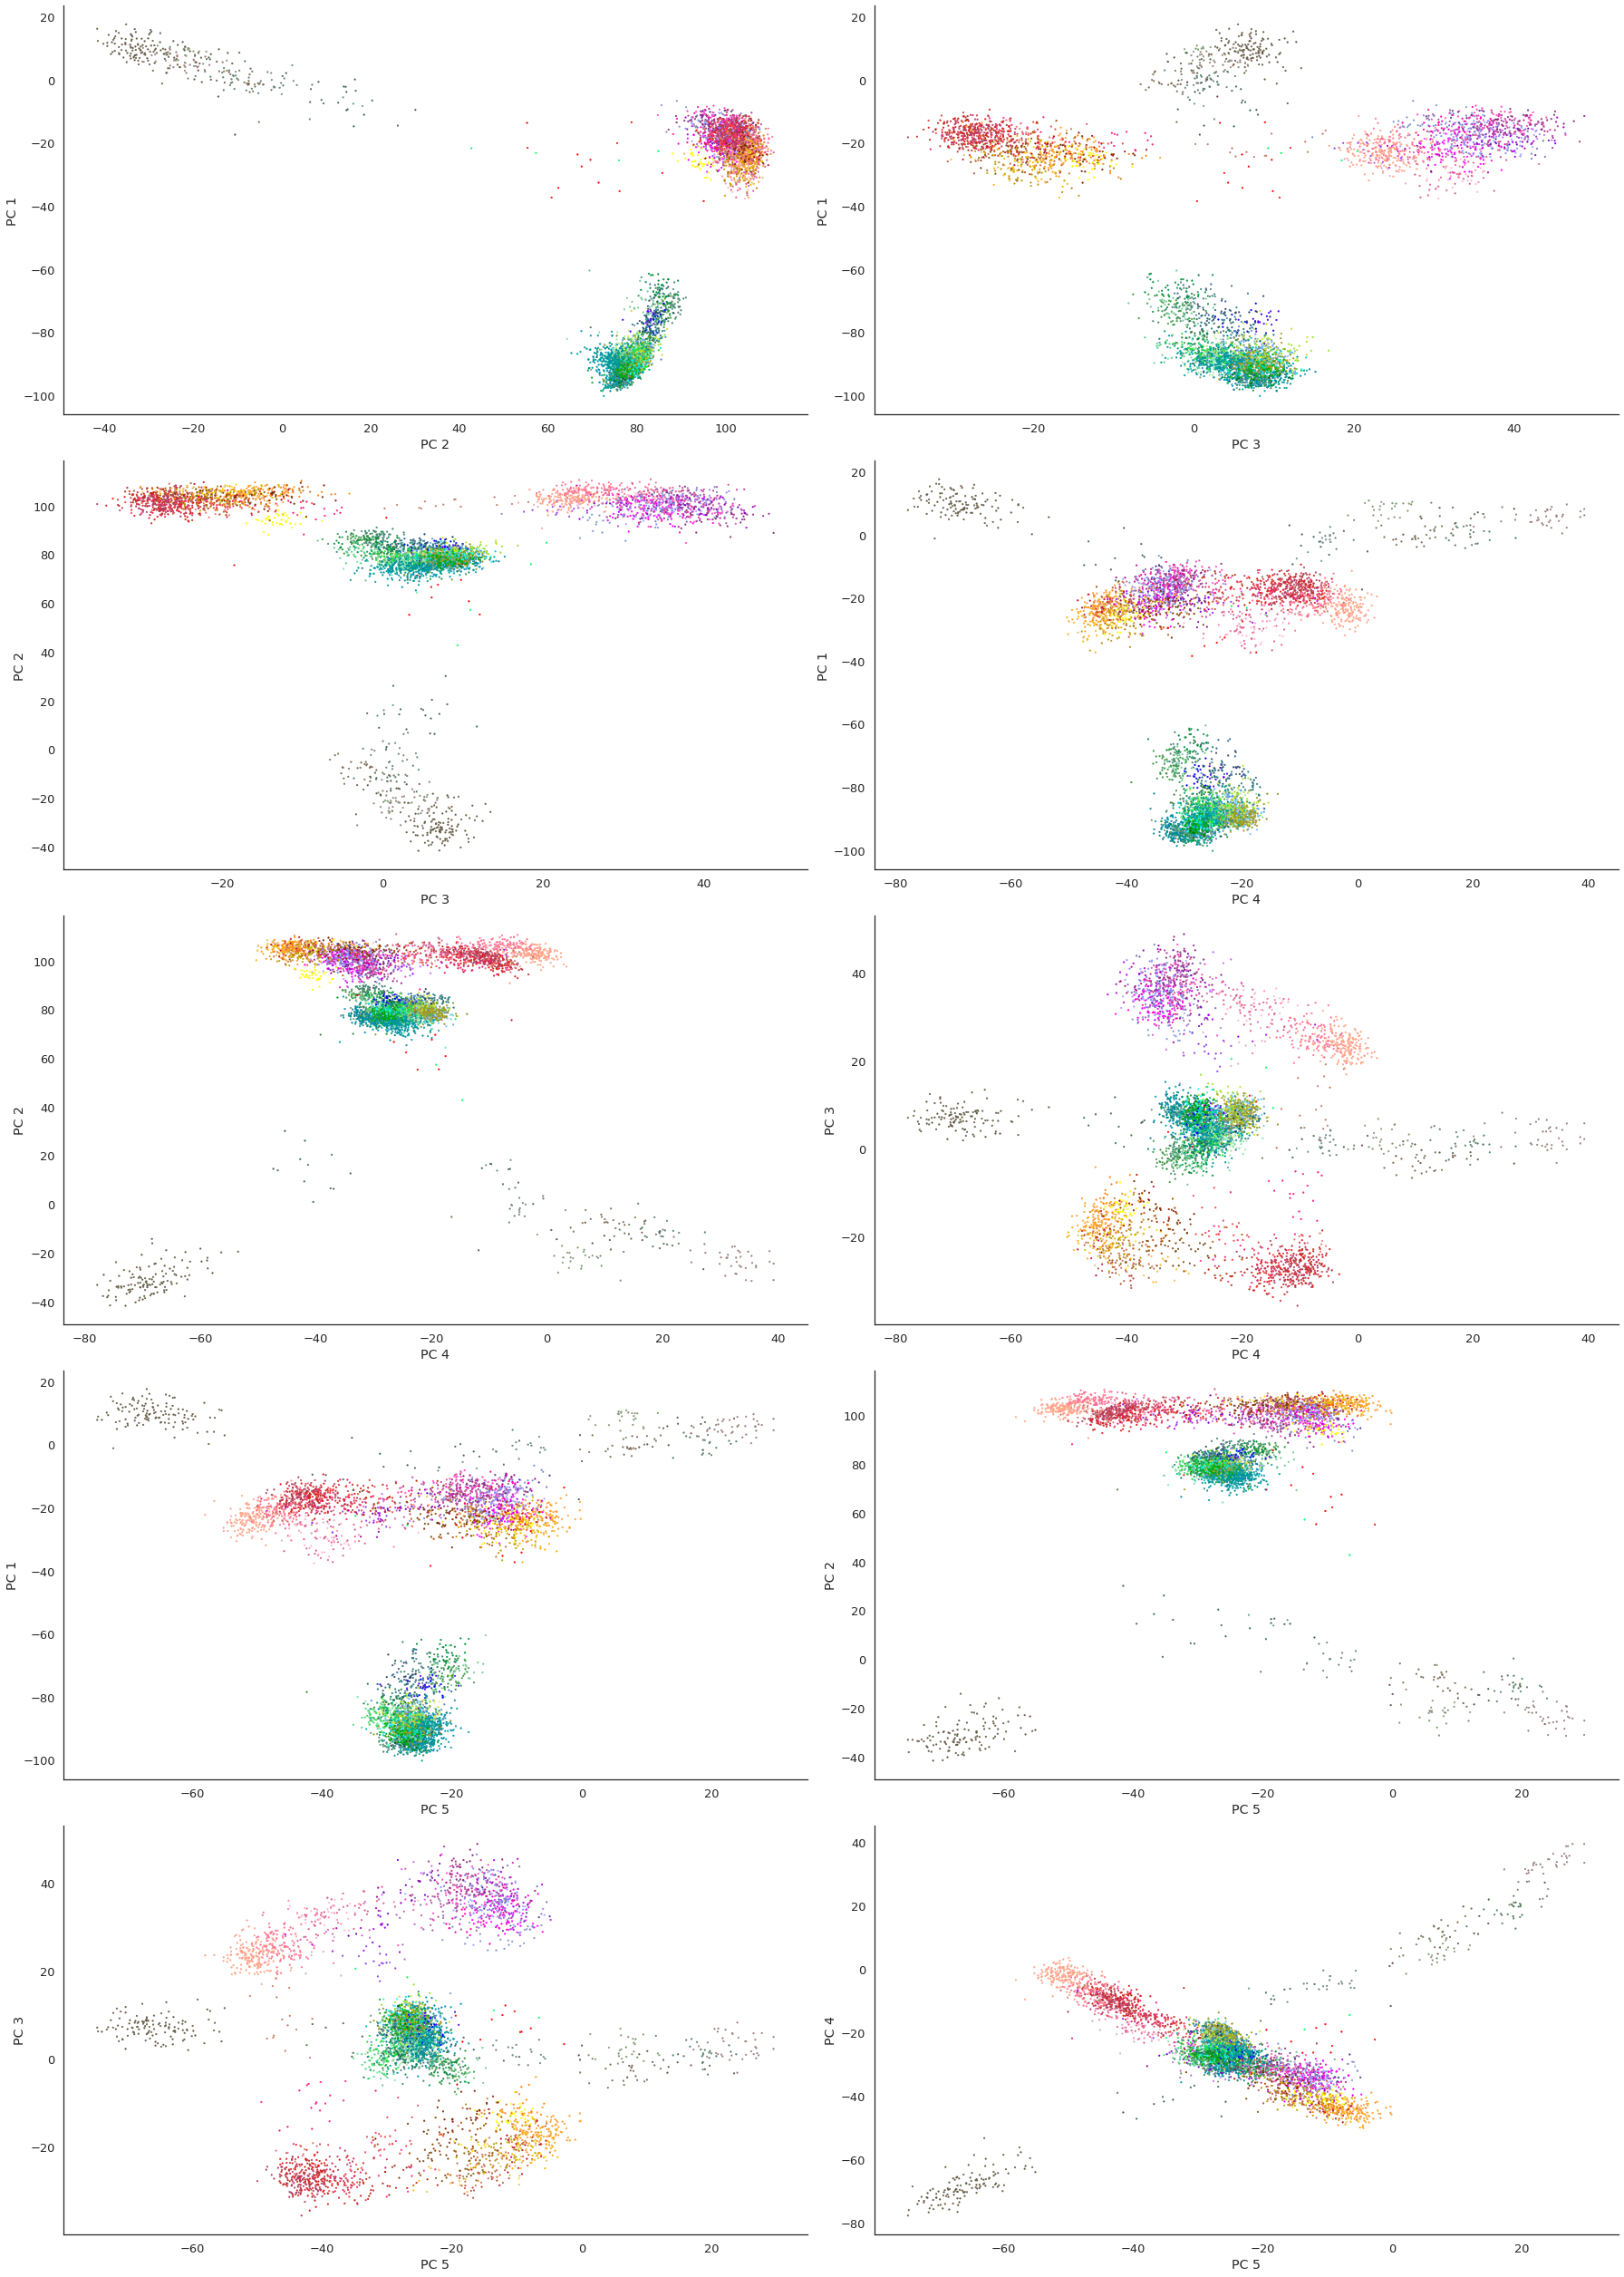

In [14]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'],color_per_datapoint)

YOUR ANSWER HERE

## Task 2: Comparison with PCA implemented by sklearn [5 pts]

We provide the results of the sklearn PCA to make sure you have the same PCA-transformed data as everyone else in the class in the remaining tasks and obtain some insights into numerical precision of the algorithms underlying PCA implementations.

In [15]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # INSERT YOUR CODE HERE

    
    ### TO BE REMOVED ###    
    pca = PCA(svd_solver='full').fit(data)
    data_transformed = pca.transform(data)    
    principal_components = pca.components_.T
    fraction_variance_explained = pca.explained_variance_ratio_
    ### TO BE REMOVED ###
    
    return fraction_variance_explained, principal_components

In [16]:
#do sklearn-PCA on selected genes
var_expl_sklearn,PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
#select components as before
_,PCs_sklearn75 = select_PCs(var_expl_sklearn,PCs_sklearn,0.75)
#get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'],PCs_sklearn75)

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principle components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained..)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). Explain what you see. Is the agreement perfect? If not, why not?

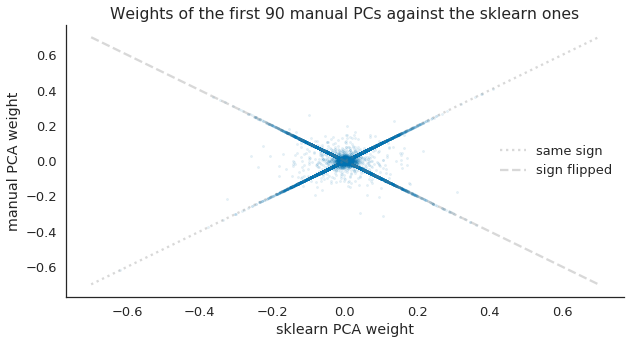

In [34]:
n_evs_to_compare=90
    
plt.figure(figsize=(10,5))
plt.scatter(PCs_sklearn[:,:n_evs_to_compare].flatten(),PCs[:,:n_evs_to_compare].flatten(),s=5,alpha=0.1)
plt.plot([-.7,.7],[-.7,.7],':',c='tab:gray',label='same sign',alpha=0.3)
plt.plot([-.7,.7],[.7,-.7],'--',c='tab:gray',label='sign flipped',alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

In [50]:
for pc_id in [85,86,87,88,89,90]:
    print('PC #%u\n' % (pc_id),'sklearn:',PCs_sklearn[:5,pc_id])
    print(' manual: ',PCs[:5,pc_id],'\n')

PC #85
 sklearn: [-0.00392872  0.00994615  0.00860339  0.00106828 -0.04378149]
 manual:  [ 0.00392872 -0.00994615 -0.00860339 -0.00106828  0.04378149] 

PC #86
 sklearn: [ 0.0050671   0.0111035  -0.00183549 -0.00219335 -0.04003994]
 manual:  [ 0.0050671   0.0111035  -0.00183549 -0.00219335 -0.04003994] 

PC #87
 sklearn: [ 0.00996482 -0.00640376 -0.00647567  0.0038817   0.00095174]
 manual:  [ 0.00105155 -0.00542883 -0.00239154  0.00599282 -0.01347785] 

PC #88
 sklearn: [ 0.00103559 -0.00670992 -0.00236122 -0.0083578   0.07419216]
 manual:  [-0.00996482  0.00640376  0.00647567 -0.0038817  -0.00095174] 

PC #89
 sklearn: [-0.00220742  0.00268683 -0.00523946  0.00673732 -0.0593084 ]
 manual:  [ 0.0069753  -0.00526621 -0.01042463  0.00013038  0.03652664] 

PC #90
 sklearn: [-0.00133668 -0.0081731   0.00994625 -0.00297247  0.0050901 ]
 manual:  [ 0.00103559 -0.00670992 -0.00236122 -0.0083578   0.07419216] 



YOUR ANSWER HERE

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE [5 pts]

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. First, run the default t-SNE and store the result in a variable you keep, as you will use it for plotting in the next tasks as well. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance as provided in ```tasic_1k['PCA_75']```.

You can use sklearn implementation of t-SNE.

In [17]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.
    
    input:
        tsne_results: (n,2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''
    
    if type(tsne_results)==list: # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters)==list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters]*num_plots
    
    if len(labels)==1:
        labels = labels*num_plots
        
    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than 
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'],tasic_1k['clusterColors'][:n_extra_colors]))    
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots,1,figsize=(10,num_plots*10))
    if num_plots==1:
        if not np.all(tasic_1k['clusters']==clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:,0], tsne_results[0][:,1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters']==clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:,0], tsne_results[i][:,1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()
            
            

In [18]:
tsne_default = TSNE(random_state=1)
tsne_results = tsne_default.fit_transform(tasic_1k['PCA_75'])
original_clusters = tasic_1k['clusters']

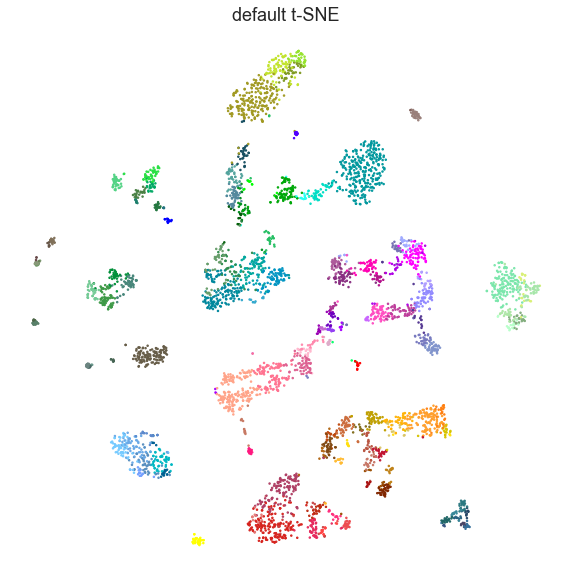

In [19]:
plot_tsne(tsne_results,original_clusters,labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

In [20]:
#try different perplexities

# INSERT YOUR CODE HERE

### TO BE REMOVED ###
tsne_perplexity=[tsne_results]
for perplexity in [5,100]:
    tsne_perp = TSNE(perplexity=perplexity,random_state=1)
    tsne_perplexity.append(tsne_perp.fit_transform(tasic_1k['PCA_75']))
### TO BE REMOVED ###


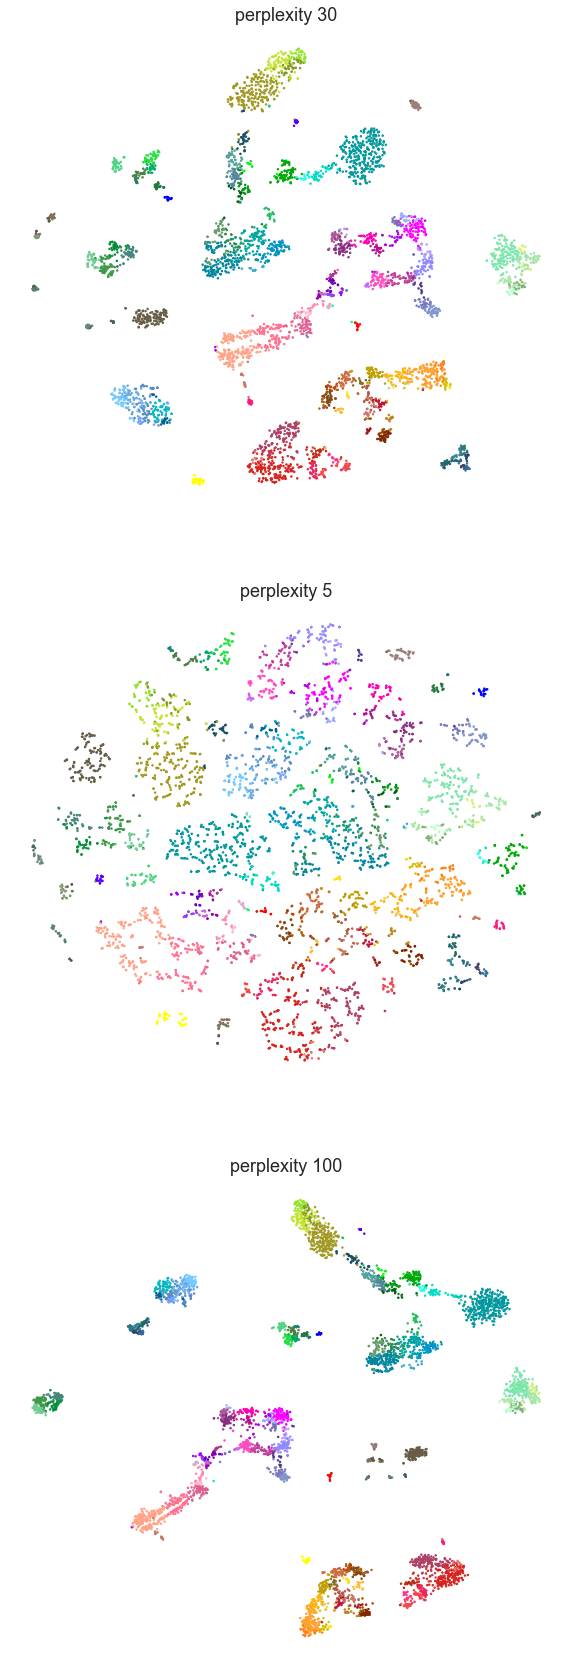

In [21]:
#plot results

# INSERT YOUR CODE HERE

#### TO BE REMOVED ###
plot_tsne(tsne_perplexity,original_clusters,labels=['perplexity 30', 'perplexity 5', 'perplexity 100'])

YOUR ANSWER HERE

## Task 4: Cluster the data using k-Means [5 pts]

So far, we only visualized the data and plotted it with the original cluster labels. As a next step, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters. Plot your results as  t-SNE colored by clusters and compare them to the original clusters. Describe your results.

In [22]:
def run_KMeans(n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        input: number of clusters
        output: Cluster labels (K-means prediction)
    '''
    
    # INSERT YOUR CODE HERE
    
    ### TO BE REMOVED ###    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(tasic_1k['PCA_75'])
    kmeans_result = kmeans.predict(tasic_1k['PCA_75'])
    ### TO BE REMOVED ###    
    return kmeans_result

In [23]:
#run kmeans

# INSERT YOUR CODE HERE


### TO BE REMOVED ###    
kmeans_clusterings = []
for num_clusters in [5,10,20,50]:
    kmeans_clusterings.append(run_KMeans(num_clusters))
### TO BE REMOVED ###

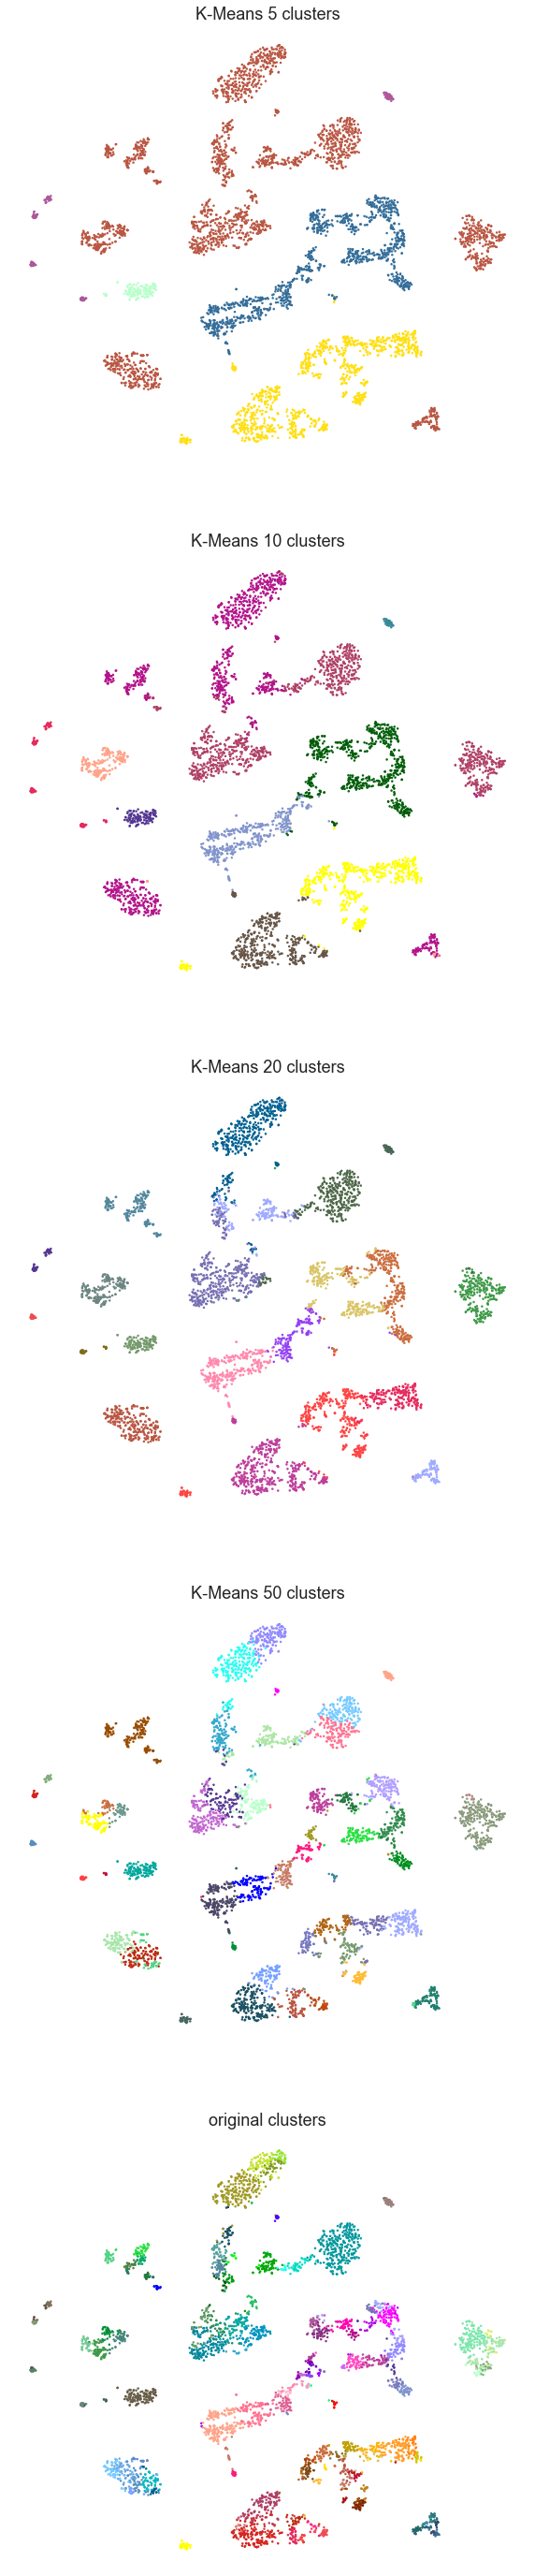

In [24]:
#plot results

# INSERT YOUR CODE HERE

### TO BE REMOVED ###    
kmeans_labels = ['K-Means 5 clusters', 'K-Means 10 clusters', 'K-Means 20 clusters', 'K-Means 50 clusters']
plot_tsne(tsne_results,kmeans_clusterings+[tasic_1k['clusters']],\
          labels =  kmeans_labels + ['original clusters'])

YOUR ANSWER HERE

##  Task 5: Clustering using Gaussian Mixture Models [20 points]

Finally, we will implement clustering with Gaussian Mixture models. To this end, we will first generate toy data to later verify the correct implementation of the algorithm and then implement the algorithm using EM and run it on the transcriptomics data set. 

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_4 = \begin{bmatrix}0\\2\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

In [56]:
def sampleData(N, means, covariances, priors):
    '''Generate N samples from a Mixture of Gaussian distribution.
    
    inputs:
        N           -- number of samples
        means       -- (n_cluster,n_dimensions)-shaped array of mean vectors
        covariances -- (n_dimensions,n_dimensions,n_cluster)-shaped array of covariance matrices
        prioirs     -- (n_cluster)-shaped arrays of priors / mixing coefficients
    outputs:
        data        -- (N,n_dimensions)-shaped array of simulated data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point

    '''
    
    # INSERT YOUR CODE HERE

    ### TO BE REMOVED ###    
    n_components = priors.shape[0]
    n_dimensions = covariances.shape[0]
    
    n_samples = (N*priors).astype(int)
    n_samples_cumsum = np.cumsum(n_samples)
   
    data = np.zeros((sum(n_samples),n_dimensions))*np.nan
    cluster_ids = np.zeros((N))*np.nan
    

        
    for i,(n_sample,n_total_samples) in enumerate(zip(n_samples,n_samples_cumsum)):
        #sample for one component and save results
        start_idx = n_total_samples-n_sample
        end_idx = n_total_samples
        data[start_idx:end_idx,:] = np.random.multivariate_normal(means[i,:],covariances[:,:,i],int(n_sample))
        cluster_ids[start_idx:end_idx] = i*np.ones((int(n_sample)))
    ### TO BE REMOVED ###    

    
    return data,cluster_ids 

In [57]:
#set up sampling

# INSERT YOUR CODE HERE


### TO BE REMOVED ###
N = 1000
toy_means = np.array([[0, 0], [5, 1], [0, 4]])
toy_cov1 = np.array([[1, 0], [0, 1]])
toy_cov2 = np.array([[2, 1], [1, 2]])
toy_cov3 = np.array([[1, -.5], [-.5, 1]])
toy_covs = np.concatenate((toy_cov1[:,:,np.newaxis],
                    toy_cov2[:,:,np.newaxis],
                    toy_cov3[:,:,np.newaxis]), axis=2)
toy_priors = np.array([.3, .5, .2])
### TO BE REMOVED ###    

toy_data, toy_cluster_ids_true = sampleData(N, toy_means, toy_covs, toy_priors)

In [58]:
def plot_clustering(data,cluster_ids,means,title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (N,n_dimensions)-shaped array of data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_cluster,n_dimensions)-shaped array of mean vectors
        title       -- string that is added as title

    '''
    
    # INSERT YOUR CODE HERE
    
    plt.figure(figsize=(6, 6))

    ### TO BE REMOVED ###
    for cluster_id in np.unique(cluster_ids):
        index = cluster_ids==cluster_id
        plt.plot(data[index,0],data[index,1],'.',markersize=3) 
    plt.plot(means[:,0],means[:,1],'s')
    plt.title(title)
    sns.despine()
    plt.show()
    ### TO BE REMOVED ###    



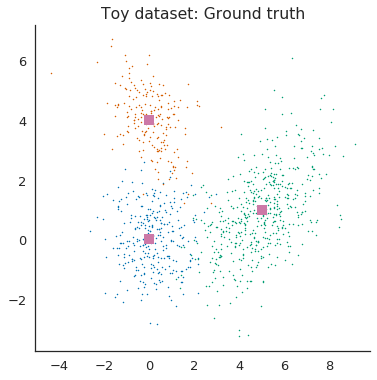

In [59]:
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: Ground truth')

Implement the EM algorithm to fit a Gaussian mixture model on the PCA-transformed data.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-6}$) to the diagonal.

In [30]:
def gmm(data,n_components,verbose=True,max_iter=1000):
    '''Function that fits a mixture of gaussians to data.
    
        inputs:
            data          -- (n_samples,n_features)-shaped array of data points
            n_components  -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
    
        outputs:
            cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_cluster,n_dimensions)-shaped array of fit mean vectors
            covs        -- (n_dimensions,n_dimensions,n_cluster)-shaped array of fit covariance matrices
            priors     -- (n_cluster)-shaped arrays of fit priors / mixing coefficients
        
        '''
    
    
    # INSERT YOUR CODE HERE

    
    ### TO BE REMOVED ### 
    n_samples = np.shape(data)[0]
    n_dimensions = np.shape(data)[1]
    
    

    ### INITIALIZATION ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###  
    
    #run kmeans to find nice approximations of cluster centers and initial covariance matricies to speed up EM
    kmeans = KMeans(n_clusters=n_components).fit(data)
    kmeans_cluster_ids = kmeans.labels_
    #means from k means
    init_means = kmeans.cluster_centers_
    #covariance matrix from the data points belonging to a certain k means cluster
    init_covs = np.nan*np.zeros((n_components,n_dimensions,n_dimensions))
    for cluster_id in range(n_components):
        init_covs[cluster_id,:,:] = np.cov(data[kmeans_cluster_ids==cluster_id,:],rowvar=False)
    #mixing coefficients as proportions of the clusters
    kmeans_unique_cluster_ids,kmeans_cluster_counts = np.unique(kmeans_cluster_ids,return_counts=True)
    init_priors = kmeans_cluster_counts / n_samples
    #initial log likelihood
    LLH_old = 0    
    n_iter=0
    LLH_change=np.Inf
    convergence_threshold = 1e-4    
    priors = init_priors
    means = init_means
    covs = init_covs
    
    
    
    
    ### ALTERNATE BETWEEN E & M STEP ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###  
    while n_iter < max_iter and LLH_change > convergence_threshold:        
        n_iter += 1
        
        
        
        ### E-STEP ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###  
        #maximum likelihood for each datapoint to belong to the k-th cluster
        posterior_numerator = np.nan*np.zeros([n_samples,n_components])
        for component_id in range(n_components):
            mu =means[component_id,:]
            #add constant to covarinace to avoid singularity
            sigma = covs[component_id,:,:]+np.eye(n_dimensions)*1e-6
            posterior_numerator[:,component_id] = priors[component_id]*sp.stats.multivariate_normal.pdf(data, mean=mu,cov=sigma)
        #compute normalization (total LLH per sample)
        normalization = np.sum(posterior_numerator,axis=1,keepdims=True)
        #compute posterior (samples x components) LLH/normalization   
        posterior = posterior_numerator / normalization
        
        


        ### M-STEP ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###    
        for component_id in range(n_components):
            #update means 
            means[component_id,:] = np.average(data,axis=0,weights=posterior[:,component_id])
            #update covariance matrices
            covs[component_id,:,:] = np.cov(data,rowvar=False,aweights=posterior[:,component_id])        
        #update mixing coefficient
        priors = np.sum(posterior,axis=0)/n_samples
        
        
            
        
        ### CHECK FOR CONVERGENCE ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###      
        LLH_new = np.sum(np.log(np.sum(posterior_numerator,axis=1)),axis=0)        
        LLH_change = np.abs(LLH_new-LLH_old)
        if verbose:
            print('iteration:',str(n_iter),' --- log LLH:',str(LLH_new),' --- LLH change:',str(LLH_change))        
        LLH_old = LLH_new       
               
    if (LLH_change < convergence_threshold):
        print('Clustering with %u components did converge after %u iterations.' % (n_components,n_iter))
    else:
        print('Clustering with %u components did not converge.' % (n_components))

    
    ### ASSIGN CLUSTER LABELS ### ###  MAYBE KEEP THIS COMMENT AS SKELETON ###  
    #classify data points to cluster by taking the cluster with the largest of the k posterior values for that data point
    cluster_ids = np.argmax(posterior,axis=1)
    #reshape covs to D x D x k
    covs = np.transpose(covs)
    ### TO BE REMOVED ###
    
    
    return (cluster_ids, means, covs, priors)


Test your implementation on the toy dataset specifying the correct number of clusters and make sure the code works correctly. 

In [31]:
toy_cluster_ids_fit, toy_means_fit, toy_covs_fit, toy_priors_fit = gmm(toy_data,3)

iteration: 1  --- log LLH: -4123.576096093899  --- LLH change: 4123.576096093899
iteration: 2  --- log LLH: -4111.520410474024  --- LLH change: 12.055685619874566
iteration: 3  --- log LLH: -4105.310654927098  --- LLH change: 6.209755546926317
iteration: 4  --- log LLH: -4101.846016046384  --- LLH change: 3.4646388807141193
iteration: 5  --- log LLH: -4100.175491586344  --- LLH change: 1.6705244600398146
iteration: 6  --- log LLH: -4099.430838307025  --- LLH change: 0.7446532793192091
iteration: 7  --- log LLH: -4099.10299281201  --- LLH change: 0.32784549501502624
iteration: 8  --- log LLH: -4098.955397905676  --- LLH change: 0.14759490633332462
iteration: 9  --- log LLH: -4098.886631108349  --- LLH change: 0.0687667973270436
iteration: 10  --- log LLH: -4098.853420289543  --- LLH change: 0.03321081880676502
iteration: 11  --- log LLH: -4098.836831408722  --- LLH change: 0.016588880820563645
iteration: 12  --- log LLH: -4098.828290631185  --- LLH change: 0.008540777536836686
iteration

Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

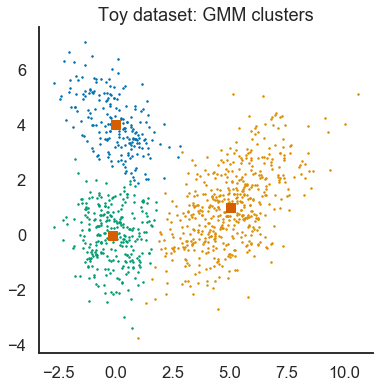

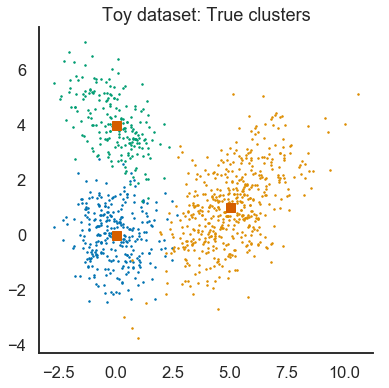

In [32]:
plot_clustering(toy_data,toy_cluster_ids_fit,toy_means_fit,'Toy dataset: GMM clusters')
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: True clusters')

Now apply your GMM implementation to the transcriptomics data using `n=50` clusters (as for the k-Means algorithm above). Compare the result to the result of the k-Means algorithm and the original clustering labels provided by the authors. 

In [33]:
### TO BE REMOVED ###
labels_gmm, _, _, _, = gmm(tasic_1k['PCA_75'],n_components=50)
### TO BE REMOVED ###

iteration: 1  --- log LLH: -424703.999567545  --- LLH change: 424703.999567545
iteration: 2  --- log LLH: -424517.8124570561  --- LLH change: 186.1871104889433
iteration: 3  --- log LLH: -424398.87734265043  --- LLH change: 118.9351144056418
iteration: 4  --- log LLH: -424361.67568376625  --- LLH change: 37.20165888417978
iteration: 5  --- log LLH: -424337.75813490176  --- LLH change: 23.917548864497803
iteration: 6  --- log LLH: -424322.1041558895  --- LLH change: 15.653979012276977
iteration: 7  --- log LLH: -424315.70553223445  --- LLH change: 6.398623655026313
iteration: 8  --- log LLH: -424315.4630527237  --- LLH change: 0.24247951077995822
iteration: 9  --- log LLH: -424314.86742289  --- LLH change: 0.5956298336968757
iteration: 10  --- log LLH: -424313.4038586938  --- LLH change: 1.4635641961940564
iteration: 11  --- log LLH: -424312.58489692595  --- LLH change: 0.8189617678290233
iteration: 12  --- log LLH: -424312.38512967515  --- LLH change: 0.19976725080050528
iteration: 13 

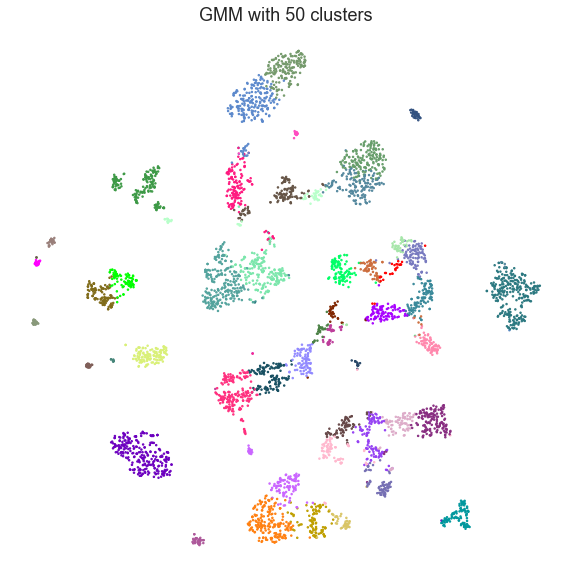

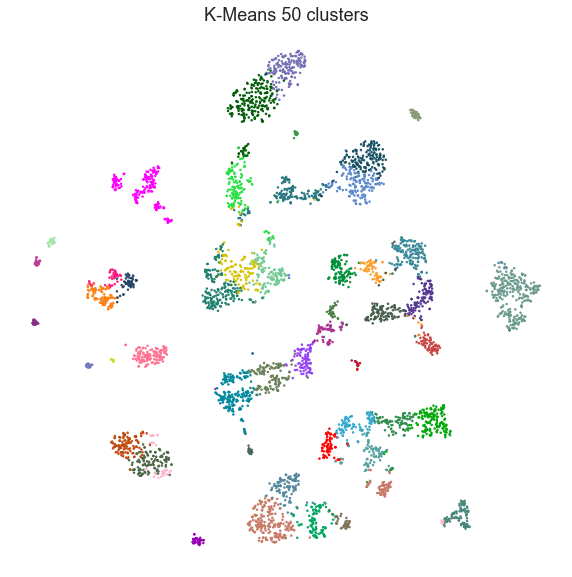

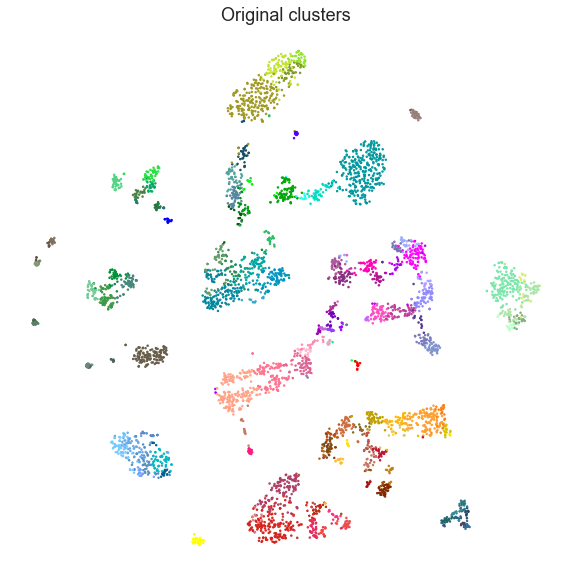

In [34]:
### TO BE REMOVED ###
plot_tsne(tsne_results,labels_gmm,['GMM with 50 clusters'])
plot_tsne(tsne_results,kmeans_clusterings[3],[kmeans_labels[3]])
plot_tsne(tsne_results,original_clusters,labels=['Original clusters'])
### TO BE REMOVED ###